<a href="https://colab.research.google.com/github/NguyenNhan1992/Advanced-Deep-Learning-with-Keras/blob/master/VAE_Mnist_corrected_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
accelerator = 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image


# # transform = transforms.Compose(
# #     [transforms.ToTensor(),
# #      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform = transforms.Compose(
#     [transforms.ToTensor()])

# trainset = torchvision.datasets.MNIST(root='./data', train=True,
#                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(torch.randn(15, 8, 240, 240, 1), batch_size=4,
                                          shuffle=True, num_workers=2)
# testset = torchvision.datasets.MNIST(root='./data', train=False,
#                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(torch.randn(5, 8, 240, 240, 1), batch_size=4,
                                         shuffle=False, num_workers=2)


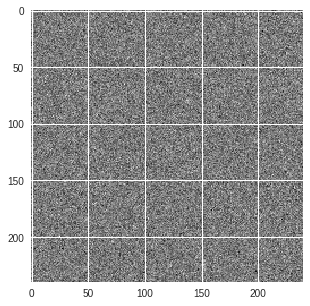

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0,1,...])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [0]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x, layerName = 'default'):
        # Do your print / debug stuff here
        print(layerName+': {}'.format(x.shape))
        return x

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
class UnFlatten(nn.Module):
    def forward(self, input, size=8):
        return input.view(input.size(0), size, 1, 1)

In [0]:
class CVAE(nn.Module):
    def __init__(self, nChannels, W, H, _channel):
        super(CVAE, self).__init__()
        import torch
        from collections import OrderedDict

        self.nChannels = nChannels
        self.W = W
        self.H = H
        self._channel = _channel

        self.encoder = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv3d(nChannels, 16, (3, 3, 3), stride=(1, 1, 1), padding=(1,1,1),bias=False)),
#             PrintLayer(),
            ('batch_norm', nn.BatchNorm3d(16)),
            ('relu1', nn.LeakyReLU(0.2, inplace=True)),
#             ('flatten1', Flatten())
        ]))
            
        
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose3d(16, 8, (4,4,4), stride=(1,1,1), padding=(1,1,1), bias=False),
#             UnFlatten(),
            nn.ConvTranspose3d(16, 8, (3,3,3), stride=(1,1,1), padding=(1,1,1), bias=False),
            nn.BatchNorm3d(8),
            nn.Sigmoid()
        )

        self.fc1 = nn.Linear(921600, 8)
        self.fc21 = nn.Linear(8, 4)
        self.fc22 = nn.Linear(8, 4)
        

        self.fc3 = nn.Linear(4, 8)
        self.fc4 = nn.Linear(8, 921600)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        conv = self.encoder(x);
#         print("encode conv", conv.size())
        h1 = self.fc1(conv.view(-1, conv.size()[1]*conv.size()[2]*conv.size()[3]*conv.size()[4]))
#         print("encode h1", h1.size())
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z, x):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
#         print("deconv_input", deconv_input.size())
        encode_shape = self.encoder(x).size()
        deconv_input = deconv_input.view(-1, encode_shape[1],encode_shape[2],encode_shape[3],encode_shape[4])
#         print("deconv_input", deconv_input.size())
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
          eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
          eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
#         print("x", x.size())
        mu, logvar = self.encode(x)
#         print("mu, logvar", mu.size(), logvar.size())
        z = self.reparametrize(mu, logvar)
#         print("z", z.size())
        decoded = self.decode(z,x)
#         print("decoded", decoded.size())
        return decoded, mu, logvar
      
# build model
model = CVAE(8, 240, 240, 1)
if torch.cuda.is_available():
    model.to(device)

In [9]:
input = torch.randn(20, 8, 240, 240, 1)
output,_,_ = model(input.to(device))
print(output.shape)

torch.Size([20, 8, 240, 240, 1])


In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 8*240*240), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [11]:
# number of epochs to train the model
n_epochs = 30
steps = 0
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
      
      steps += 1
      # _ stands in for labels, here
      # no need to flatten images
      data = data.to(device)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      recon_batch, mu, log_var = model(data)
      loss = loss_function(recon_batch, data, mu, log_var)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update running training loss
#       train_loss += loss.item()*data.size(0)
      train_loss += loss.item()

      if steps % 1 == 0:
        print("Epoch {} Train loss: {}".format((epoch+1)/n_epochs, train_loss))
        train_loss = 0.0
            
#     # print avg training statistics 
#     train_loss = train_loss/len(train_loader)
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(
#         epoch, 
#         train_loss
#         ))

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([4, 460800])) that is different to the input size (torch.Size([4, 8, 240, 240, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0 Train loss: 1328467.0
Epoch 0 Train loss: 1327167.375
Epoch 0 Train loss: 1327585.0


/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([3, 460800])) that is different to the input size (torch.Size([3, 8, 240, 240, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 0 Train loss: 995399.75
Epoch 0 Train loss: 36842904.0
Epoch 0 Train loss: 1354807.0
Epoch 0 Train loss: 1.33983934874e+12
Epoch 0 Train loss: 997394.5625
Epoch 0 Train loss: 4346391.5
Epoch 0 Train loss: 8756836.0
Epoch 0 Train loss: 1738986.75
Epoch 0 Train loss: 1009629.875
Epoch 0 Train loss: 4270547.0
Epoch 0 Train loss: 1693954.25
Epoch 0 Train loss: 8221640.0
Epoch 0 Train loss: 993931.875
Epoch 0 Train loss: 4153353.5
Epoch 0 Train loss: 7980339.0
Epoch 0 Train loss: 1325378.5
Epoch 0 Train loss: 1341453.625
Epoch 0 Train loss: 1324908.25
Epoch 0 Train loss: 1356789.375
Epoch 0 Train loss: 4351874.0
Epoch 0 Train loss: 6921370.5
Epoch 0 Train loss: 4003632.5
Epoch 0 Train loss: 1345783.125
Epoch 0 Train loss: 6891794.0
Epoch 0 Train loss: 1321969.125
Epoch 0 Train loss: 9306643.0
Epoch 0 Train loss: 1338318.375
Epoch 0 Train loss: 1655572.375
Epoch 0 Train loss: 993827.875
Epoch 0 Train loss: 4004290.25
Epoch 0 Train loss: 6004425.0
Epoch 0 Train loss: 1343963.25
Epoch 0 

In [0]:
# def train(epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in zip(train_loader):
#         data = data.cuda()
#         optimizer.zero_grad()
        
#         recon_batch, mu, log_var = model(data)
#         loss = loss_function(recon_batch, data, mu, log_var)
        
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
        
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item() / len(data)))
#     print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [0]:
# for epoch in range(1, 5):
#     train(epoch)

In [0]:
# input = torch.randn(100, 8, 240, 240, 1)
# output = model(input)
# print(output.shape)

In [0]:
# m = nn.Conv3d(8, 16, (3, 3, 3), stride=(1, 1, 1), padding=(1,1, 1))
# input = torch.randn(100, 8, 240, 240, 1)

# output = m(input)
# print(output.shape)

In [0]:
# class netTest(nn.Module):
#     def __init__(self):
#         super(netTest, self).__init__()
#         self.conv3d = nn.Conv3d(8, 16, (3,3,3), (1,1,1), (1,1,1), bias=False)
#         self.batchnorm = nn.BatchNorm3d(16)
#         self.lrelu = nn.LeakyReLU(0.2, inplace=True)
         
#     def forward(self, x):                              # Forward pass: stacking each layer together
#         out = self.conv3d(x)
#         out = self.batchnorm(out)
#         out = self.lrelu(out)
#         return out

In [0]:
# testmodel = netTest()

In [0]:
# input = torch.randn(100, 8, 240, 240, 1)
# output = testmodel(input)
# print(output.shape)

In [0]:
# ngf = 64
# ndf = 64
# nc = 8

# class CVAE_1(nn.Module):
#     def __init__(self, nz):
#         super(CVAE, self).__init__()

#         self.nz = nz

#         self.encoder = nn.Sequential(
#             # input is (nc) x 28 x 28
#             nn.Conv2d(nc, out_channels=, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 14 x 14
#             nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 7 x 7
#             nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
#             # nn.BatchNorm2d(1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             # nn.Sigmoid()
#         )

#         self.decoder = nn.Sequential(
#             # input is Z, going into a convolution
#             nn.ConvTranspose2d(     1024, ngf * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 4 x 4
#             nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 8 x 8
#             nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(ngf),
#             # nn.ReLU(True),
#             # state size. (ngf) x 32 x 32
#             # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
#             # nn.Tanh()
#             nn.Sigmoid()
#             # state size. (nc) x 64 x 64
#         )

#         self.fc1 = nn.Linear(1024, 512)
#         self.fc21 = nn.Linear(512, nz)
#         self.fc22 = nn.Linear(512, nz)

#         self.fc3 = nn.Linear(nz, 512)
#         self.fc4 = nn.Linear(512, 1024)

#         self.lrelu = nn.LeakyReLU()
#         self.relu = nn.ReLU()
#         # self.sigmoid = nn.Sigmoid()

#     def encode(self, x):
#         conv = self.encoder(x);
#         # print("encode conv", conv.size())
#         h1 = self.fc1(conv.view(-1, 1024))
#         # print("encode h1", h1.size())
#         return self.fc21(h1), self.fc22(h1)

#     def decode(self, z):
#         h3 = self.relu(self.fc3(z))
#         deconv_input = self.fc4(h3)
#         # print("deconv_input", deconv_input.size())
#         deconv_input = deconv_input.view(-1,1024,1,1)
#         # print("deconv_input", deconv_input.size())
#         return self.decoder(deconv_input)

#     def reparametrize(self, mu, logvar):
#         std = logvar.mul(0.5).exp_()
# #         if self.have_cuda:
#         eps = torch.cuda.FloatTensor(std.size()).normal_()
# #         else:
# #             eps = torch.FloatTensor(std.size()).normal_()
#         eps = Variable(eps)
#         return eps.mul(std).add_(mu)

#     def forward(self, x):
#         # print("x", x.size())
#         mu, logvar = self.encode(x)
#         # print("mu, logvar", mu.size(), logvar.size())
#         z = self.reparametrize(mu, logvar)
#         # print("z", z.size())
#         decoded = self.decode(z)
#         # print("decoded", decoded.size())
#         return decoded, mu, logvar
      
# # build model
# model = CVAE(20)
# if torch.cuda.is_available():
#     model.cuda()

In [0]:
# from torchsummary import summary

In [0]:
# summary(model, input_size=(8, 28, 28, 1))

In [0]:
# optimizer = optim.Adam(model.parameters())
# # return reconstruction error + KL divergence losses
# def loss_function(recon_x, x, mu, log_var):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
#     KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
#     return BCE + KLD

In [0]:
# def train(epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.cuda()
#         optimizer.zero_grad()
        
#         recon_batch, mu, log_var = model(data)
#         loss = loss_function(recon_batch, data, mu, log_var)
        
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
        
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item() / len(data)))
#     print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [0]:
# def test():
#     model.eval()
#     test_loss= 0
#     with torch.no_grad():
#         for data, _ in test_loader:
#             data = data.cuda()
#             recon, mu, log_var = model(data)
            
#             # sum up batch loss
#             test_loss += loss_function(recon, data, mu, log_var).item()
        
#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

In [0]:
# for epoch in range(1, 5):
#     train(epoch)
#     test()